# **Biomarker Selection for CLL and T2D**

This notebook performs feature selection to identify significant biomarkers for Chronic Lymphocytic Leukemia (CLL) and Type 2 Diabetes (T2D) using a merged gene expression dataset. Three feature selection methods—Lasso, Random Forest, and SVM-RFE—are applied to rank and select biomarkers. The intersection of selected features is identified, and a t-test is used to verify the statistical significance of the common biomarkers. The results are saved for further analysis.

### **1. Import Libraries**

The following libraries are imported for data manipulation, visualization, statistical testing, and machine learning-based feature selection.

In [96]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

### **2. Load Dataset**

The merged dataset containing gene expression data for CLL and T2D is loaded from a CSV file.

In [97]:
# Load the dataset
data = pd.read_csv('clean_data/merged_cll_t2d_data.csv')
data.head()

,SOCS1,CD3D,CCL4,IL7R,TSSC2,SAMSN1,PTPN7,CD300C,VSIG4,CXCL10,...,IFIT3,BATF3,SLFN12L,IL10,SIGLEC7,GZMH,CD7,OLR1,S100A8,label
0,4.0,24.0,0.0,49.0,21.0,94.0,12.0,0.0,0.0,217.0,...,1024.0,6.0,13.0,21.0,0.0,8.0,0.0,21.0,38.0,0.0
1,5.0,14.0,0.0,97.0,19.0,51.0,17.0,5.0,0.0,214.0,...,1958.0,20.0,15.0,23.0,0.0,6.0,2.0,52.0,53.0,1.0
2,7.0,8.0,0.0,46.0,27.0,43.0,13.0,12.0,44.0,134.0,...,1320.0,0.0,10.0,14.0,3.0,0.0,0.0,44.0,25.0,0.0
3,9.0,8.0,3.0,37.0,25.0,146.0,2.0,0.0,0.0,86.0,...,750.0,0.0,21.0,10.0,0.0,0.0,0.0,67.0,16.0,0.0
4,9.0,25.0,0.0,77.0,24.0,67.0,21.0,20.0,36.0,41.0,...,1125.0,15.0,14.0,75.0,0.0,0.0,0.0,68.0,35.0,1.0


### **3. Select Features and Target**

The dataset is split into features (X: gene expression values) and the target variable (y: labels indicating disease status).

In [98]:
# Select features and target variable (X, y)
X = data.drop(columns=['label'])
y = data['label']

# Print the shape of the dataset
print(f"Shape of the dataset: {X.shape}, {y.shape}")

Shape of the dataset: (146, 59), (146,)


### **4. Standardize Features**

Features are standardized using StandardScaler to ensure comparability, as many ML algorithms (e.g., SVM) are sensitive to feature scales.

In [99]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [100]:
# Make a dataframe from the scaled features
X = pd.DataFrame(X, columns=data.columns[:-1])

### **5. Visualize Class Distribution**

A count plot visualizes the distribution of classes (e.g., healthy, T2D, CLL) in the dataset.

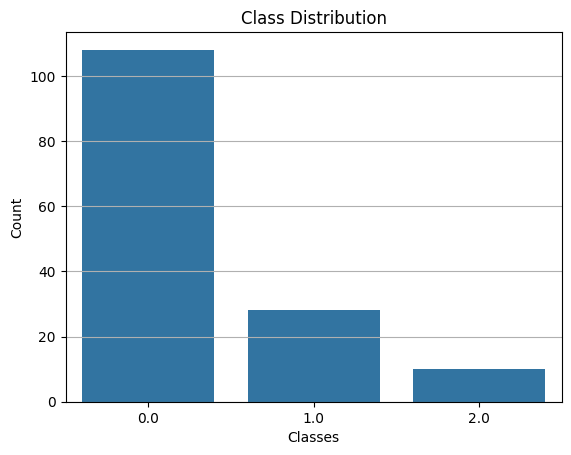

In [101]:
# Visualize the class distribution
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

### **6. Handle Class Imbalance (Commented Out)**

The code for handling class imbalance using SMOTE is present but commented out. It would upsample the minority class and visualize the new class distribution.

Resampled dataset shape: (324, 59), (324,)


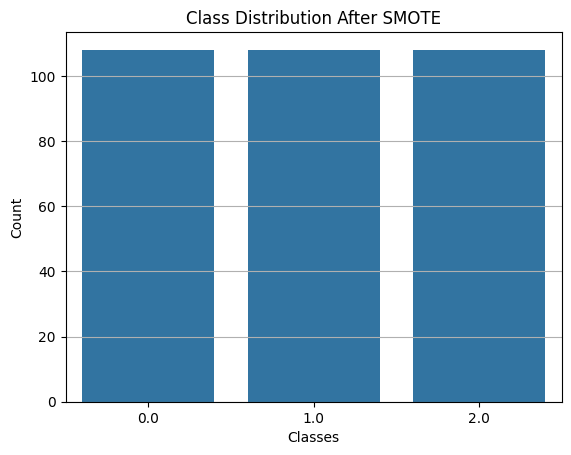

In [102]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
# print the shapesbefore and after SMOTE
print(f"Resampled dataset shape: {X.shape}, {y.shape}")
# Visualize the class distribution after SMOTE
sns.countplot(x=y)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

### **7. Lasso Feature Selection**

A Lasso model is trained to select features by shrinking less important feature coefficients to zero. The absolute values of the coefficients are used to rank features.

In [103]:
# Train Lasso model and perform feature selection s
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
importance = np.abs(lasso.coef_)
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)
lasso_feature_importance = feature_importance[feature_importance['Importance'] > 0]
# Print the selected features
print("Number of Biomarkers selected by Lasso:", len(lasso_feature_importance))
print("Selected Biomarkers using Lasso:")
print(lasso_feature_importance)

Number of Biomarkers selected by Lasso:

 25
Selected Biomarkers using Lasso:
     Feature  Importance
0      PTPN7    0.241794
1      SOCS1    0.138049
2       GZMB    0.131219
3     SEMA6B    0.097751
4     CLEC5A    0.086481
5       APOD    0.083404
6      TSSC2    0.075062
7      IFIT3    0.072434
8    SIGLEC7    0.059557
9       IL10    0.059466
10      CCL7    0.053899
11     FSIP1    0.052554
12      FPR1    0.042821
13     CD209    0.042450
14      NKG7    0.027744
15      PPBP    0.025125
16    CXCL10    0.023511
17      FLT4    0.014136
18      MT1E    0.013578
19   SLFN12L    0.009928
20  PDCD1LG2    0.009638
21     VSIG4    0.008389
22    LILRB4    0.008281
23    LRRC25    0.007798
24     BATF3    0.000393


### **8. Random Forest Feature Selection**

A Random Forest model is trained to select features based on their importance scores, derived from their contribution to classification.

In [104]:
# Train Random Forest model and perform feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importance = rf.feature_importances_
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)
rf_feature_importance = feature_importance[feature_importance['Importance'] > 0]
# Print the selected features
print("Number of Biomarkers selected by Random Forest:", len(rf_feature_importance))
print("Selected Biomarkers using Random Forest:")
print(rf_feature_importance)

Number of Biomarkers selected by Random Forest: 59
Selected Biomarkers using Random Forest:
     Feature  Importance
0        CD7    0.075134
1      IL2RB    0.071939
2      PTPN7    0.060632
3       PRF1    0.060381
4       NKG7    0.042406
5      CYTIP    0.037331
6       IL1B    0.033082
7    IL18RAP    0.031262
8     SAMSN1    0.030500
9    SLFN12L    0.030314
10     FSIP1    0.027740
11      CD3G    0.026947
12    LRRC25    0.021961
13      IL7R    0.021245
14      APOD    0.020855
15    SEMA6B    0.020504
16      GZMH    0.019981
17    S100A8    0.018298
18    CD300E    0.018013
19      CD3D    0.015341
20     CXCR6    0.013852
21       ITK    0.013243
22     SOCS1    0.012894
23     IL2RA    0.011725
24    CLEC5A    0.011688
25     TSSC2    0.010935
26      MT1E    0.010926
27      CCL5    0.010624
28    CD300C    0.010516
29     THBS1    0.010382
30      CCL3    0.009898
31     GPR84    0.009840
32    FCGR3A    0.009249
33    LILRB4    0.009162
34      CCL7    0.009074
35      

### **9. SVM-RFE Feature Selection**

SVM-RFE is used to select the top 10 features by iteratively eliminating the least important features based on SVM weights.

In [105]:
# Train SVM-RFE model and perform feature selection
svm = SVC(kernel='linear', random_state=42)
rfe = RFE(estimator=svm, n_features_to_select=10)
rfe.fit(X, y)
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rfe.ranking_})
# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)
svmrfe_feature_importance = feature_importance[feature_importance['Importance'] > 0.0]
# Print the selected features
print("Number of Biomarkers selected by SVM-RFE:", len(svmrfe_feature_importance))
print("Selected Biomarkers using SVM-RFE:")
print(svmrfe_feature_importance)

Number of Biomarkers selected by SVM-RFE: 59
Selected Biomarkers using SVM-RFE:
     Feature  Importance
0     FCGR3A          50
1       FLT4          49
2      KLRC1          48
3     GIMAP6          47
4       FPR1          46
5       CD3D          45
6       PRF1          44
7     S100A8          43
8        ITK          42
9        CD7          41
10      IDO1          40
11      CCL4          39
12    CD300E          38
13    CD300C          37
14      MT2A          36
15     IL2RA          35
16     CD209          34
17      CCL3          33
18    SAMSN1          32
19     IL2RB          31
20      GZMH          30
21     TSSC2          29
22      PPBP          28
23     BATF3          27
24  PDCD1LG2          26
25      OLR1          25
26      CCL7          24
27     GPR84          23
28      CCL5          22
29      CD3G          21
30     IFIT3          20
31      GZMA          19
32    CCL4L2          18
33      IL1B          17
34     THBS1          16
35      MT1E        

### **10. Intersection of Selected Features**

The common biomarkers selected by all three methods (Lasso, Random Forest, and SVM-RFE) are identified.

In [106]:
# Intersection of selected features from all three methods
lasso_features = set(lasso_feature_importance['Feature'])
rf_features = set(rf_feature_importance['Feature'])
svmrfe_features = set(svmrfe_feature_importance['Feature'])
intersection_features = lasso_features.intersection(rf_features).intersection(svmrfe_features)
# Print the intersection of selected features
print("Number of Biomarkers in intersection:", len(list(intersection_features)))
print("Intersection of Selected Biomarkers:")
print(intersection_features)

# Common biomarkers from previous methods
# ['TRIM10', 'NDUFA8', 'HSCB', 'TIMM8B']

Number of Biomarkers in intersection: 25
Intersection of Selected Biomarkers:
{'IFIT3', 'PDCD1LG2', 'LRRC25', 'FPR1', 'NKG7', 'CLEC5A', 'FSIP1', 'SIGLEC7', 'PTPN7', 'CD209', 'LILRB4', 'CXCL10', 'MT1E', 'GZMB', 'FLT4', 'PPBP', 'SLFN12L', 'SEMA6B', 'BATF3', 'VSIG4', 'APOD', 'SOCS1', 'IL10', 'TSSC2', 'CCL7'}


### **11. Compile Selected Features with Scores**

A DataFrame is created to compile the importance scores from all three methods for the common biomarkers.



In [ ]:
# Create a new DataFrame with the selected features with scores from all three methods
# Create a list to store rows
rows = []
for feature in intersection_features:
    lasso_score = lasso_feature_importance[lasso_feature_importance['Feature'] == feature]['Importance'].values[0]
    rf_score = rf_feature_importance[rf_feature_importance['Feature'] == feature]['Importance'].values[0]
    svmrfe_score = svmrfe_feature_importance[svmrfe_feature_importance['Feature'] == feature]['Importance'].values[0]
    rows.append({
        'Feature': feature,
        'Lasso': lasso_score,
        'Random Forest': rf_score,
        'SVM-RFE': svmrfe_score
    })

selected_features = pd.DataFrame(rows)
# Print the selected features with scores
print("Selected Biomarkers with Scores:")
print(selected_features)
# Save to CSV
selected_features.to_csv('results/cll_t2d_multimode_selected_features.csv', index=False)

Selected Biomarkers with Scores:
     Feature     Lasso  Random Forest  SVM-RFE
0      IFIT3  0.072434       0.008679       20
1   PDCD1LG2  0.009638       0.006165       26
2     LRRC25  0.007798       0.021961        6
3       FPR1  0.042821       0.008496       46
4       NKG7  0.027744       0.042406        1
5     CLEC5A  0.086481       0.011688        1
6      FSIP1  0.052554       0.027740        1
7    SIGLEC7  0.059557       0.007340        5
8      PTPN7  0.241794       0.060632       13
9      CD209  0.042450       0.007979       34
10    LILRB4  0.008281       0.009162        1
11    CXCL10  0.023511       0.005205        2
12      MT1E  0.013578       0.010926       15
13      GZMB  0.131219       0.007217        1
14      FLT4  0.014136       0.005363       49
15      PPBP  0.025125       0.006422       28
16   SLFN12L  0.009928       0.030314       11
17    SEMA6B  0.097751       0.020504        1
18     BATF3  0.000393       0.006377       27
19     VSIG4  0.008389     

### **12. Verify Common Biomarkers with T-test**

A t-test is performed to verify the statistical significance of the common biomarkers by comparing their expression levels between healthy (label 0) and T2D (label 1) groups.

In [108]:
# Verify the common biomarkers with t-test
# Load the dataset again
data = pd.read_csv('clean_data/merged_cll_t2d_data.csv')
# Select features and target variable (X, y)
X = data.drop(columns=['label'])
y = data['label']
# Select the common biomarkers
common_biomarkers = list(intersection_features)
# Create a new DataFrame with the common biomarkers
common_biomarkers_df = data[common_biomarkers]
# Add the target variable
common_biomarkers_df['label'] = y
# Perform t-test for each common biomarker
t_test_results = []
for feature in common_biomarkers:
    group1 = common_biomarkers_df[common_biomarkers_df['label'] == 0][feature]
    group2 = common_biomarkers_df[common_biomarkers_df['label'] == 1][feature]
    t_stat, p_value = ttest_ind(group1, group2)
    t_test_results.append({
        'Feature': feature,
        't-statistic': t_stat,
        'p-value': p_value
    })
# Create a DataFrame for t-test results
t_test_results_df = pd.DataFrame(t_test_results)
# Print the t-test results
print("T-test Results:")
print(t_test_results_df.sort_values(by='p-value', ascending=True).reset_index(drop=True))
# Save t-test results to CSV
t_test_results_df.to_csv('results/cll_t2d_multimode_t_test_results.csv', index=False)

# Common biomarkers from previous methods
# ['TRIM10', 'NDUFA8', 'HSCB', 'TIMM8B']

T-test Results:
     Feature  t-statistic   p-value
0       APOD    -3.297298  0.001250
1       CCL7    -2.709209  0.007626
2       GZMB    -2.238023  0.026870
3     SEMA6B     1.983165  0.049393
4       MT1E    -1.950671  0.053183
5      FSIP1     1.720976  0.087563
6      TSSC2     1.718639  0.087990
7     LRRC25     1.417743  0.158587
8       IL10    -1.313042  0.191413
9      CD209     1.304802  0.194196
10    LILRB4     1.196734  0.233523
11     PTPN7     1.128860  0.260974
12   SIGLEC7     1.075002  0.284306
13      FLT4     0.987705  0.325077
14   SLFN12L     0.954819  0.341388
15    CLEC5A    -0.823284  0.411809
16     VSIG4    -0.785104  0.433779
17  PDCD1LG2     0.754316  0.451983
18     IFIT3     0.628005  0.531070
19     SOCS1    -0.495325  0.621182
20      PPBP    -0.478335  0.633191
21      FPR1     0.357383  0.721367
22      NKG7     0.354687  0.723382
23     BATF3    -0.245564  0.806396
24    CXCL10    -0.215904  0.829391


/tmp/ipykernel_11215/3768257735.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_biomarkers_df['label'] = y


In [111]:
# print the genes with p-value < 0.05
significant_genes = t_test_results_df[t_test_results_df['p-value'] < 0.05].sort_values(by='p-value', ascending=True).reset_index(drop=True)
print("Significant Genes:")
print(significant_genes)
# Save significant genes to CSV
significant_genes.to_csv('results/cll_t2d_multimode_significant_genes.csv', index=False)

Significant Genes:
  Feature  t-statistic   p-value
0    APOD    -3.297298  0.001250
1    CCL7    -2.709209  0.007626
2    GZMB    -2.238023  0.026870
3  SEMA6B     1.983165  0.049393
